# 1. Introduction and problem statement

Every day many customers around the world are sending inquires and need support in relation to their interaction with the company. This is specifically the case for B2C markets, where customers are many. With todays advancement in technological possibilities, many support services are taking place online, where customers send in their written inquires. But how do they companies handle this large pool of customer inquiries with many different support needs? 

I will in this notebook show how a company can use NLP to create a LLM-based classifier so that each inquiry can be classified and send the right department in the company to enhance efficiency

**Dataset:** I will use a kaggle dataset which is a synthetic custommer support ticket dataset for a tech company: https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset/data

In [50]:
import kagglehub
import pandas as pd
import glob
import os

# Download latest version
path = kagglehub.dataset_download("suraj520/customer-support-ticket-dataset")
print("Dataset path:", path)

# Find first CSV file in the downloaded dataset
csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)
if not csv_files:
    raise FileNotFoundError("No CSV files found in dataset folder.")

# Load the first CSV
df = pd.read_csv(csv_files[0])

print("Loaded CSV:", os.path.basename(csv_files[0]))
print("Shape:", df.shape)



Dataset path: /Users/anderssonderby/.cache/kagglehub/datasets/suraj520/customer-support-ticket-dataset/versions/1
Loaded CSV: customer_support_tickets.csv
Shape: (8469, 17)


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [80]:
df.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating,Predicted Label
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,"I'm having an issue with the GoPro Hero. Please assist. Your billing zip code is: 71701. We appreciate that you have requested a website address. Please double check your email address. I've tried troubleshooting steps mentioned in the user manual, but the issue persists.",Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN,Technical issue
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,"I'm having an issue with the LG Smart TV. Please assist. If you need to change an existing product. I'm having an issue with the LG Smart TV. Please assist. If The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.",Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN,Technical issue
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,"I'm facing a problem with my Dell XPS. The Dell XPS is not turning on. It was working fine until yesterday, but now it doesn't respond. 1.8.3 I really I'm using the original charger that came with my Dell XPS, but it's not charging properly.",Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,Technical issue
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,"I'm having an issue with the Microsoft Office. Please assist. If you have a problem you're interested in and I'd love to see this happen, please check out the Feedback. I've already contacted customer support multiple times, but the issue remains unresolved.",Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,Technical issue
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the Autodesk AutoCAD. Please assist. Note: The seller is not responsible for any damages arising out of the delivery of the battleground game. Please have the game in good condition and shipped to you I've noticed a sudden decrease in battery life on my Autodesk AutoCAD. It used to last much longer.,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,Technical issue


We can from the `.info()` function see that we have 8469 tickets and a total of 17 columns, which refers many different variables in relation to each ticket. Most important for our problem is to look into the `Ticket Description`and also `Ticket Type`and/or `Ticket Subject` to find out which column is most relevant for our classifier

In [52]:
pd.set_option('display.max_colwidth', None)
df['Ticket Description'].head()

0                                                  I'm having an issue with the {product_purchased}. Please assist.\n\nYour billing zip code is: 71701.\n\nWe appreciate that you have requested a website address.\n\nPlease double check your email address. I've tried troubleshooting steps mentioned in the user manual, but the issue persists.
1                                                    I'm having an issue with the {product_purchased}. Please assist.\n\nIf you need to change an existing product.\n\nI'm having an issue with the {product_purchased}. Please assist.\n\nIf The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.
2                                                               I'm facing a problem with my {product_purchased}. The {product_purchased} is not turning on. It was working fine until yesterday, but now it doesn't respond.\n\n1.8.3 I really I'm using the original charger that came with my {product_purchased}, but it

From viewing the first couple of ticket description we can see that there are some things to be aware of in the data cleaning part. First of all the `product_purchased` is encoded as product_purchased which then would refer to the column in the dataset `product_purchased`. Thus we could consider imputing the relevant product purchased into each ticket description to make a more clear description for our LLM to work with. Otherwise we should create it as a stopword for our LLM. Also we have many line breaks `/n` which we need to handle

In [53]:
print(df['Ticket Type'].value_counts())
print('--'*50)
print(df['Ticket Subject'].value_counts())

Ticket Type
Refund request          1752
Technical issue         1747
Cancellation request    1695
Product inquiry         1641
Billing inquiry         1634
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Ticket Subject
Refund request              576
Software bug                574
Product compatibility       567
Delivery problem            561
Hardware issue              547
Battery life                542
Network problem             539
Installation support        530
Product setup               529
Payment issue               526
Product recommendation      517
Account access              509
Peripheral compatibility    496
Data loss                   491
Cancellation request        487
Display issue               478
Name: count, dtype: int64


From the value counts of both the type and subject we can see that there is a nice distribution. For the sake of simplicity but also relevance, we will use the `Ticket Type` as our target as it refers to 5 relevant types of tickets which then different departments of the customer service department can focus on

# 2. Data cleaning

First of all we will clean the ticket descriptions so we can make the ticket descriptions most clear.

In [54]:
# Removing all line breaks
df['Ticket Description'] = df['Ticket Description'].str.replace('\n', ' ', regex=True)
df['Ticket Description'].head(1)

0    I'm having an issue with the {product_purchased}. Please assist.  Your billing zip code is: 71701.  We appreciate that you have requested a website address.  Please double check your email address. I've tried troubleshooting steps mentioned in the user manual, but the issue persists.
Name: Ticket Description, dtype: object

Now we are also going to replace the `product purchased` in the ticket description with the actual products purchased from the same row as that will hopefully help the LLM integrating more information on the ticket. 

In [55]:
# Function to replace placeholder with actual product name
def replace_product(description, product):
    if pd.isna(description):  # handle missing text
        return description
    if pd.isna(product):      # handle missing product name
        product = "product"
    return description.replace('{product_purchased}', str(product))

# Apply the replacement for each row
df['Ticket Description'] = df.apply(
    lambda row: replace_product(row['Ticket Description'], row['Product Purchased']),
    axis=1
)

# Preview result
df['Ticket Description'].head(3)


0    I'm having an issue with the GoPro Hero. Please assist.  Your billing zip code is: 71701.  We appreciate that you have requested a website address.  Please double check your email address. I've tried troubleshooting steps mentioned in the user manual, but the issue persists.
1             I'm having an issue with the LG Smart TV. Please assist.  If you need to change an existing product.  I'm having an issue with the LG Smart TV. Please assist.  If The issue I'm facing is intermittent. Sometimes it works fine, but other times it acts up unexpectedly.
2                                     I'm facing a problem with my Dell XPS. The Dell XPS is not turning on. It was working fine until yesterday, but now it doesn't respond.  1.8.3 I really I'm using the original charger that came with my Dell XPS, but it's not charging properly.
Name: Ticket Description, dtype: object

# 3. API connection - Gemini

I am going to use Gemini's 2.5 flash-lite model as the LLM which we are going to call via an API

In [56]:
from openai import OpenAI
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

client = None
if not api_key:
    print("⚠️ Set GEMINI_API_KEY in environment or a .env file")
else:
    # Configure the OpenAI client to point to Google's endpoint
    client = OpenAI(
        api_key=api_key,
        base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
    )
    print("✅ OpenAI client configured for Gemini.")

✅ OpenAI client configured for Gemini.


In [57]:
def check_api_access(client=None):
    """Checks if the API can be accessed via the OpenAI-style client.

    Tries to use a passed `client` first, otherwise looks for a global `client`.
    Handles different response shapes gracefully.
    """
    # Resolve client
    if client is None:
        client = globals().get("client")

    if not client:
        print("❌ Client not configured. Please set API key and initialize the OpenAI client as `client = OpenAI(...)`.")
        return False

    try:
        completion = client.chat.completions.create(
            model="gemini-2.5-flash-lite",
            messages=[{"role": "user", "content": "Hello, world!"}],
            timeout=10
        )

        # Robust extraction of text from various response shapes
        content = None
        try:
            content = completion.choices[0].message.content
        except Exception:
            try:
                content = completion.choices[0].text
            except Exception:
                content = getattr(completion, "text", None)

        print("✅ API access confirmed.")
        print(f"Response: {content}")
        return True

    except Exception as e:
        print(f"❌ API error: {e}")
        print("Please ensure your API key is correct and you have internet access.")
        return False

# Run the check
check_api_access()

✅ API access confirmed.
Response: Hello there! How can I help you today?


True

# 3. Baseline classifier

In this section we will create a baseline model where our LLM will try and classify the customer inquiries without previous examples to learn from

In [58]:
from pydantic import BaseModel, Field
from typing import Literal

# ✅ Allowed ticket types
ALLOWED_TICKET_TYPES = [
    "Refund request",
    "Technical issue",
    "Cancellation request",
    "Product inquiry",
    "Billing inquiry"
]

# ✅ Pydantic schema for structured output
class SingleLabelPrediction(BaseModel):
    predicted_label: Literal[
        "Refund request",
        "Technical issue",
        "Cancellation request",
        "Product inquiry",
        "Billing inquiry"
    ] = Field(description="The best-fit ticket type label for the given ticket description.")

# ✅ Zero-shot classification function
# ...existing code...
def classify_ticket(description: str) -> str:
    """
    Call the LLM and return a plain label string.
    Handles common SDK response shapes.
    """
    if client is None:
        raise ValueError("Client not configured. Initialize `client = OpenAI(...)` with your API key.")

    prompt = f"""
You are a customer support classifier.
Classify the following ticket description into ONE of these categories:
- Refund request
- Technical issue
- Cancellation request
- Product inquiry
- Billing inquiry

Ticket description:
\"\"\"{description}\"\"\"

Respond only with the most appropriate label.
"""

    try:
        resp = client.chat.completions.create(
            model="gemini-2.5-flash-lite",
            messages=[
                {"role": "system", "content": "You are a precise and reliable classifier for support tickets."},
                {"role": "user", "content": prompt},
            ],
            timeout=20
        )
    except Exception as e:
        raise RuntimeError(f"LLM request failed: {e}")

    # Try common response shapes to extract the label
    label = None
    try:
        label = resp.choices[0].message.content.strip()
    except Exception:
        pass
    if not label:
        try:
            label = resp.choices[0].text.strip()
        except Exception:
            pass
    if not label:
        try:
            candidate = resp[0] if hasattr(resp, "__getitem__") else resp
            label = getattr(candidate, "predicted_label", None)
            if isinstance(label, str):
                label = label.strip()
        except Exception:
            pass
    if not label:
        label = (getattr(resp, "text", "") or "").strip() or None

    if not label:
        raise RuntimeError(f"Could not extract label from model response. Inspect response: {repr(resp)[:1000]}")

    return label





### Batch Processing

As i only have 15 requests per minute from Gemini's model, i will do batch processing to make predictions on the first 100 tickets. This means that the LLM will predict 10 at a time:

In [62]:
import json

batch_size = 10
sample_tickets = df["Ticket Description"].head(100)
predicted_labels = []

for i in range(0, len(sample_tickets), batch_size):
    batch = sample_tickets[i:i+batch_size]
    
    # Prepare prompt
    prompt = "Classify the following tickets into one of these categories: Refund request, Technical issue, Cancellation request, Product inquiry, Billing inquiry.\n\n"
    for idx, ticket in enumerate(batch, 1):
        prompt += f"Ticket {idx}: {ticket}\n"
    prompt += "\nRespond with a JSON array of labels in order, e.g. [\"Refund request\", \"Technical issue\", ...]"

    # LLM call
    resp = client.chat.completions.create(
        model="gemini-2.5-flash-lite",
        messages=[
            {"role": "system", "content": "You are a precise and reliable classifier for support tickets."},
            {"role": "user", "content": prompt},
        ],
        timeout=30
    )

    # Extract text
    text = resp.choices[0].message.content.strip()

    # Remove backticks if present
    if text.startswith("```") and text.endswith("```"):
        text = "\n".join(text.split("\n")[1:-1])

    # Parse JSON
    try:
        labels = json.loads(text)
        if not isinstance(labels, list) or len(labels) != len(batch):
            raise ValueError("Unexpected JSON structure")
    except Exception as e:
        raise RuntimeError(f"Failed to parse labels from model:\n{text}\nError: {e}")

    predicted_labels.extend(labels)

# Save predicted labels
df.loc[:len(predicted_labels)-1, "Predicted Label"] = predicted_labels






In [63]:
df['Predicted Label'].value_counts()

Predicted Label
nan                8369
Technical issue      97
Refund request        2
Billing inquiry       1
Name: count, dtype: int64

So by running through the first 100 we can see that the classifier 97 times predict the label as a technical issue. Let us look into that problem. We are going to run a general classification report and an accuracy score first:

In [64]:
# Calculate precision and recall
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(
    df['Ticket Type'].head(100),
    df['Predicted Label'].head(100),
    labels=ALLOWED_TICKET_TYPES,
    zero_division=0
)
print(report)

accuracy_1 = accuracy_score(
    df['Ticket Type'].head(100),
    df['Predicted Label'].head(100)
)
print(f"Overall accuracy on ticket types: {accuracy_1:.2f}")

                      precision    recall  f1-score   support

      Refund request       0.00      0.00      0.00        18
     Technical issue       0.26      0.93      0.40        27
Cancellation request       0.00      0.00      0.00        17
     Product inquiry       0.00      0.00      0.00        21
     Billing inquiry       0.00      0.00      0.00        17

            accuracy                           0.25       100
           macro avg       0.05      0.19      0.08       100
        weighted avg       0.07      0.25      0.11       100

Overall accuracy on ticket types: 0.25


So the overall accuracy is 25% which relates to the fact the our classifier almost classifies all tickets as technical issues and there are 27 technical issues in the 100 observation we predicted from.

Let us look into the descriptions and see why this problem occurs


In [65]:
# Filter mismatches
mismatches = df[df["Predicted Label"] != df["Ticket Type"]]

# Preview first 10 mismatches
print(mismatches[["Ticket Description", "Predicted Label", "Ticket Type"]].head(5))


                                                                                                                                                                                                                                                                                                                                  Ticket Description  \
3                                                                                I'm having an issue with the Microsoft Office. Please assist.  If you have a problem you're interested in and I'd love to see this happen, please check out the Feedback. I've already contacted customer support multiple times, but the issue remains unresolved.   
4            I'm having an issue with the Autodesk AutoCAD. Please assist.   Note: The seller is not responsible for any damages arising out of the delivery of the battleground game. Please have the game in good condition and shipped to you I've noticed a sudden decrease in battery life on my Autodesk AutoCAD. 

So looking at the first 5 mismatches we can see why the classifier predicts as it does. In the Ticket Description the customer actually only describes their issue and not their specific inquiry or request. Thus it would be difficult for an LLM to display anything but a technical issue as the ticket type. Also when looking into the description we can actually interpret them as being kind of the interaction between the customer and the service department. This means that the descriptions might be too messy or unclear for an LLM to work with

So based on this observation it will actually be difficult to create a classifier that can classify the Ticket type based on the descriptions as the descriptions mostly contain the technincal issue that the customer face with the product, but not the actual action that they want in relation to this issue.

**New Plan:** We will look into the `Ticket Subject` variable instead and see if we can create a more reliable classifier:

In [67]:
df['Ticket Subject'].value_counts()

Ticket Subject
Refund request              576
Software bug                574
Product compatibility       567
Delivery problem            561
Hardware issue              547
Battery life                542
Network problem             539
Installation support        530
Product setup               529
Payment issue               526
Product recommendation      517
Account access              509
Peripheral compatibility    496
Data loss                   491
Cancellation request        487
Display issue               478
Name: count, dtype: int64

We are going to try to create a classifier that can predict the Ticket subject instead. For simplicity i am going to create second dataset where i then remove some of the subject and only focus on 5 for testing purposes. The 5 chosen subjects mosly relates to `Technical Issues` as we can see the model mostly finds the descriptions as technical issues

In [68]:
df_2 = df.copy()
selected_subjects = ["Software bug", "Product compatibility", "Hardware issue", "Battery life", "Network problem"]
df_2 = df_2[df_2['Ticket Subject'].isin(selected_subjects)]
df_2 = df_2.reset_index(drop=True)
print(df_2['Ticket Subject'].value_counts())
print(df_2.shape)

Ticket Subject
Software bug             574
Product compatibility    567
Hardware issue           547
Battery life             542
Network problem          539
Name: count, dtype: int64
(2769, 18)


So now we have 2769 tickets to work with and only 5 possible Ticket subjects to focus on. We are going to begin again with the **baseline model** where we do zero-shot classification, just to get a feeling about if the LLM have more succes with predicting the Ticket Subject.

In [71]:

from pydantic import BaseModel, Field
from typing import Literal

# ===============================
# Allowed ticket subjects
# ===============================
ALLOWED_TICKET_SUBJECTS = [
    "Software bug",
    "Product compatibility",
    "Hardware issue",
    "Battery life",
    "Network problem"
]

# Optional Pydantic schema
class SingleLabelPrediction(BaseModel):
    predicted_subject: Literal[
        "Software bug",
        "Product compatibility",
        "Hardware issue",
        "Battery life",
        "Network problem"
    ] = Field(description="The best-fit ticket subject label for the given ticket description.")

# ===============================
# Zero-shot classification function
# ===============================
def classify_ticket(description: str) -> str:
    """Call Gemini LLM and return the predicted subject as a string."""
    if client is None:
        raise ValueError("Client not configured. Initialize `client = OpenAI(...)` with your API key.")
    
    prompt = f"""
You are a customer support ticket classifier.
Classify the following ticket description from a tech company into ONE of these categories:
- Software bug
- Product compatibility
- Hardware issue
- Battery life
- Network problem

Ticket description:
\"\"\"{description}\"\"\"

Respond only with the most appropriate label.
"""
    resp = client.chat.completions.create(
        model="gemini-2.5-flash-lite",
        messages=[
            {"role": "system", "content": "You are a precise and reliable classifier for support tickets."},
            {"role": "user", "content": prompt},
        ],
        timeout=20
    )

    text = resp.choices[0].message.content.strip()

    # Remove Markdown ``` wrapping if present
    if text.startswith("```") and text.endswith("```"):
        lines = text.split("\n")
        text = "\n".join(lines[1:-1])

    return text.strip()




In [81]:
import json

batch_size = 10
sample_tickets = df_2["Ticket Description"].head(100)
predicted_subjects = []

for i in range(0, len(sample_tickets), batch_size):
    batch = sample_tickets[i:i + batch_size]

    # Prepare prompt
    prompt = (
        "You are a customer support classifier.\n"
        "Classify each of the following ticket descriptions into exactly ONE of these categories:\n"
        "- Software bug\n"
        "- Product compatibility\n"
        "- Hardware issue\n"
        "- Battery life\n"
        "- Network problem\n\n"
    )

    for idx, ticket in enumerate(batch, 1):
        prompt += f"Ticket {idx}: {ticket}\n"

    prompt += (
        "\nRespond with a JSON array of the predicted subjects in order, "
        "e.g. [\"Software bug\", \"Network problem\", ...]"
    )

    # LLM call
    resp = client.chat.completions.create(
        model="gemini-2.5-flash-lite",
        messages=[
            {"role": "system", "content": "You are a precise and reliable classifier for technical support tickets."},
            {"role": "user", "content": prompt},
        ],
        timeout=30,
    )

    # Extract text
    text = resp.choices[0].message.content.strip()

    # Remove code fences if present
    if text.startswith("```") and text.endswith("```"):
        text = "\n".join(text.split("\n")[1:-1]).strip()

    # Parse JSON response
    try:
        labels = json.loads(text)
        if not isinstance(labels, list) or len(labels) != len(batch):
            raise ValueError("Unexpected JSON format or wrong number of labels")
    except Exception as e:
        raise RuntimeError(f"Failed to parse labels from model:\n{text}\nError: {e}")

    predicted_subjects.extend(labels)

# Save results
df_2.loc[:len(predicted_subjects) - 1, "Predicted Subject"] = predicted_subjects




In [82]:
# Preview results
print(df_2.loc[:99, ["Ticket Subject", "Predicted Subject"]])

           Ticket Subject Predicted Subject
0         Network problem    Hardware issue
1            Battery life      Software bug
2            Software bug      Software bug
3          Hardware issue      Software bug
4            Software bug      Software bug
..                    ...               ...
95           Software bug      Software bug
96         Hardware issue      Software bug
97           Software bug      Battery life
98  Product compatibility   Network problem
99        Network problem      Software bug

[100 rows x 2 columns]


                       precision    recall  f1-score   support

         Software bug       0.27      0.80      0.41        25
Product compatibility       0.00      0.00      0.00        21
       Hardware issue       0.00      0.00      0.00        18
         Battery life       0.00      0.00      0.00        19
      Network problem       0.00      0.00      0.00        17

             accuracy                           0.20       100
            macro avg       0.05      0.16      0.08       100
         weighted avg       0.07      0.20      0.10       100

Overall accuracy on filtered subjects: 0.20


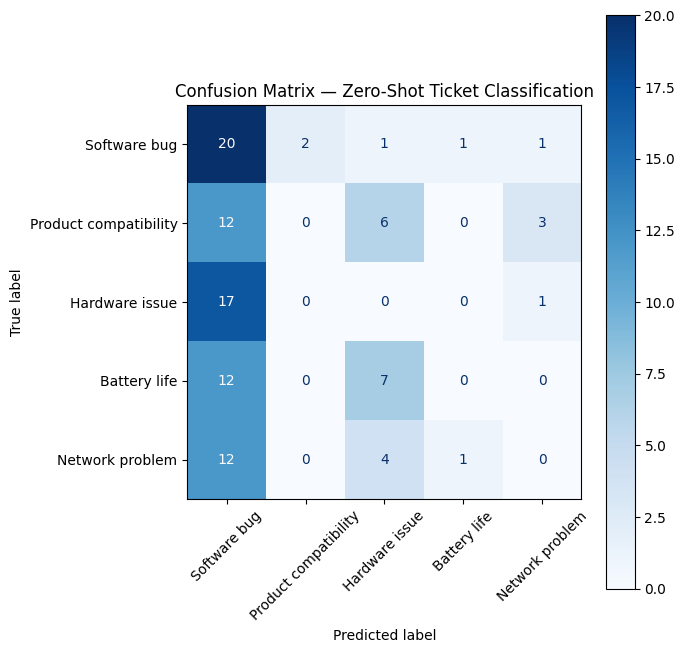

In [83]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
report_2 = classification_report(
    df_2['Ticket Subject'].head(100),
    df_2['Predicted Subject'].head(100),
    labels=ALLOWED_TICKET_SUBJECTS,
    zero_division=0
)
print(report_2)

# Overall accuracy
accuracy_2 = accuracy_score(
    df_2['Ticket Subject'].head(100),
    df_2['Predicted Subject'].head(100)
)
print(f"Overall accuracy on filtered subjects: {accuracy_2:.2f}")

#Confusion Matrix:
# True and predicted labels
y_true = df_2["Ticket Subject"].head(100)
y_pred = df_2["Predicted Subject"].head(100)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=ALLOWED_TICKET_SUBJECTS,  # ensures consistent ordering
    ax=ax,
    cmap='Blues'
)

ax.set_title("Confusion Matrix — Zero-Shot Ticket Classification")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Conclusion on zero-shot classifier:**

The classifier on Ticket Subject seems to be vulnerable to the same issue as for the classifier for type as 73 of the predicted subjects were `Software bug`. Overall the accuracy here was actually lower than in the ticket type classifier with an accuracy of 20%. Mostly coming from predicting Software bugs. Interestingly it still struggles to find the other subjects, and actually predicts those some times but can't catch them still. We could suspect that this is a data problem where the descriptions are unclear in actually what the problem is. We are going to try to improve the classifier by doing few-shot classification:

### Few-shot Classifier

I am going to start by providing some examples from the dataset for the model to learn from:

In [84]:


# We want 1 example per label for few-shot
examples = {}

for label in ALLOWED_TICKET_SUBJECTS:
    # Exclude the tickets in the batch you plan to classify
    label_rows = df_2[df_2["Ticket Subject"] == label]
    
    # Sample 1 random row safely (not including the current batch)
    example_row = label_rows.sample(1, random_state=42)  # reproducible
    examples[label] = example_row["Ticket Description"].values[0]

print(examples)


{'Software bug': "My PlayStation is making strange noises and not functioning properly. I suspect there might be a hardware issue. Can you please help me with this? Thank you! Thanks again for your help.  I'm currently in the I've noticed that the issue occurs consistently when I use a specific feature or application on my PlayStation.", 'Product compatibility': 'I\'ve forgotten my password for my Fitbit Versa Smartwatch account, and the password reset option is not working. How can I recover my account?  [Error "Invalid password for Product Purchase" when the page notifies you that I need assistance as soon as possible because it\'s affecting my work and productivity.', 'Hardware issue': "I'm having an issue with the GoPro Hero. Please assist. This problem started occurring after the recent software update. I haven't made any other changes to the device.", 'Battery life': "The Samsung Galaxy is unable to establish a stable internet connection. It keeps disconnecting intermittently. Ho

In [85]:
import json

def few_shot_classify(
    df,                       # DataFrame with tickets
    tickets_to_classify,       # Series or list of ticket descriptions
    allowed_labels,            # List of possible categories
    client,                    # Gemini client
    batch_size=10
):
    """
    Perform few-shot classification using Gemini LLM.
    Shows 1 example per label in the prompt.

    Returns a list of predicted labels.
    """
    predicted_labels = []

    for i in range(0, len(tickets_to_classify), batch_size):
        batch = tickets_to_classify[i:i + batch_size]
        current_batch_indices = batch.index if hasattr(batch, "index") else []

        # Build few-shot examples: 1 per label, excluding tickets in current batch
        examples = {}
        for label in allowed_labels:
            label_rows = df[
                (df["Ticket Subject"] == label) &
                (~df.index.isin(current_batch_indices))
            ]
            if not label_rows.empty:
                example_row = label_rows.sample(1, random_state=42)
                examples[label] = example_row["Ticket Description"].values[0]
            else:
                # fallback if no other row available
                examples[label] = f"Example {label}"

        # Construct the prompt
        few_shot_section = "Here are a few examples:\n\n"
        for label, text in examples.items():
            few_shot_section += f"Example ({label}): {text}\n"
        few_shot_section += "\nNow classify the following new tickets:\n\n"

        prompt = (
            "You are a customer support classifier.\n"
            "Classify each ticket into exactly ONE of these categories:\n"
        )
        for label in allowed_labels:
            prompt += f"- {label}\n"
        prompt += "\n" + few_shot_section

        for idx, ticket in enumerate(batch, 1):
            prompt += f"Ticket {idx}: {ticket}\n"

        prompt += (
            "\nRespond with a JSON array of predicted categories in order, "
            "e.g. [\"Software bug\", \"Network problem\", ...]"
        )

        # Call Gemini LLM
        resp = client.chat.completions.create(
            model="gemini-2.5-flash-lite",
            messages=[
                {"role": "system", "content": "You are a precise and reliable classifier for technical support tickets."},
                {"role": "user", "content": prompt},
            ],
            timeout=30,
        )

        # Extract text
        text = resp.choices[0].message.content.strip()
        if text.startswith("```") and text.endswith("```"):
            text = "\n".join(text.split("\n")[1:-1]).strip()

        # Parse JSON
        try:
            labels = json.loads(text)
            if not isinstance(labels, list) or len(labels) != len(batch):
                raise ValueError("Unexpected JSON format or wrong number of labels")
        except Exception as e:
            raise RuntimeError(f"Failed to parse labels from model:\n{text}\nError: {e}")

        predicted_labels.extend(labels)

    return predicted_labels


In [86]:
tickets_to_classify = df_2["Ticket Description"].sample(100)
predicted_subjects = few_shot_classify(
    df=df_2,
    tickets_to_classify=tickets_to_classify,
    allowed_labels=ALLOWED_TICKET_SUBJECTS,
    client=client,
    batch_size=10
)

df_2.loc[:len(predicted_subjects)-1, "Predicted Subject"] = predicted_subjects



                       precision    recall  f1-score   support

         Software bug       0.32      0.72      0.44        25
Product compatibility       0.00      0.00      0.00        21
       Hardware issue       0.15      0.28      0.20        18
         Battery life       0.00      0.00      0.00        19
      Network problem       0.20      0.06      0.09        17

             accuracy                           0.24       100
            macro avg       0.13      0.21      0.15       100
         weighted avg       0.14      0.24      0.16       100

Overall accuracy on filtered subjects: 0.24


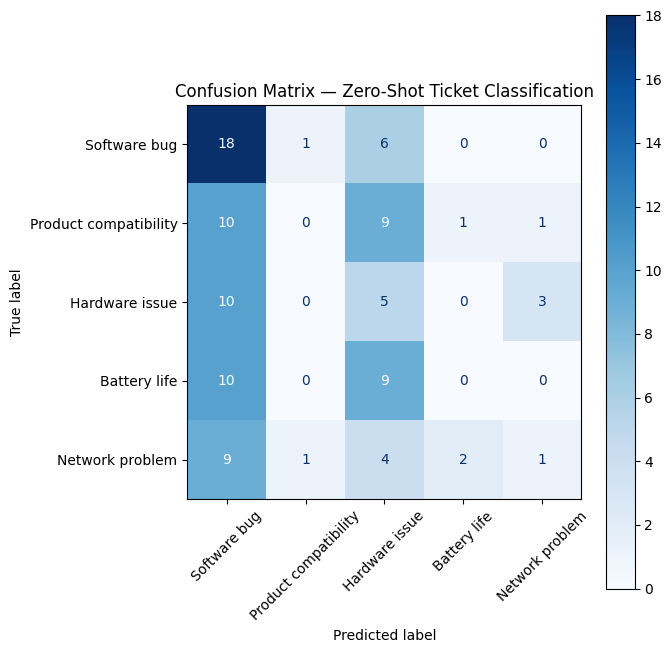

In [87]:

report_3 = classification_report(
    df_2['Ticket Subject'].head(100),
    df_2['Predicted Subject'].head(100),
    labels=ALLOWED_TICKET_SUBJECTS,
    zero_division=0
)
print(report_3)

# Overall accuracy
accuracy_3 = accuracy_score(
    df_2['Ticket Subject'].head(100),
    df_2['Predicted Subject'].head(100)
)
print(f"Overall accuracy on filtered subjects: {accuracy_3:.2f}")

#Confusion Matrix:
# True and predicted labels
y_true = df_2["Ticket Subject"].head(100)
y_pred = df_2["Predicted Subject"].head(100)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(7, 7))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=ALLOWED_TICKET_SUBJECTS,  # ensures consistent ordering
    ax=ax,
    cmap='Blues'
)

ax.set_title("Confusion Matrix — Zero-Shot Ticket Classification")
plt.xticks(rotation=45)
plt.tight_layout()

The few-shot classifier did not improve the accuracy that much. The classifier still predicts Software bug most frequently. What is interesting is that it actually also predicts Hardware issue 33 times - however only predicts correct 5 times. This could indicate that the LLM mostly rely on predicting Software or Hardware bug/issue as most problem would relate to either one of them - however it still struggles to correctly identify them. Let us look into some of the mismatches and see if we can find any substantial reasoning behind the poor performance of the classifier:

In [88]:
# Subset the first 100 rows
subset = df_2.iloc[:100]

# Identify mismatches
mismatches = subset[subset['Ticket Subject'] != subset['Predicted Subject']]

# Show first 5 mismatches
print(mismatches[['Ticket Description', 'Ticket Subject', 'Predicted Subject']].head(5))


                                                                                                                                                                                                                                                                                                                         Ticket Description  \
0                                                                                        I'm facing a problem with my Dell XPS. The Dell XPS is not turning on. It was working fine until yesterday, but now it doesn't respond.  1.8.3 I really I'm using the original charger that came with my Dell XPS, but it's not charging properly.   
1  I'm having an issue with the Philips Hue Lights. Please assist. (Thanks) I will contact all my suppliers and confirm.  Please try and find out whether their inventory is currently stocked, or any other reason. I am I've performed a factory reset on my Philips Hue Lights, hoping it would resolve the problem, but it didn't help

If we just look at the first example (0) we can understand why the classifier predicts this one wrong: 

- The customer explains that the product is not turning on and it is not charging properly. Here it is clear why the LLM predicts a Hardware Issue. For some reason this description is classified as a Network problem. 

This could indicate that there is some data issue and labeling errors and that the descriptions do not quite explain or indicate what type of subject that the ticket is classified to. 

Also if we read the second mismatch the descriptions actually contains both the customer-reported issues but also some like service-department internal communication ('I will contact all my suppliers and confirm). This will make the LLM confused and maybe a more clear prompt could have helped at least to reduce the natural confusion. 

**Overall:** The dataset had potential to be used as a create example of how a company can use NLP techniques to classify customer support tickets - however this is clearly an example of 'Garbage In - Garbage Out' and that the general description of the issue from the customers side is vital. This might be why we see that in customer inquiry platform, that the information which the company needs always need to be 'clear' and 'concise'. This could be difficult for a tech company, as many customers might have strong technical knowledge to clearly explain the issue. Most people might just explain that their product 'is not working properly', which provides very limited information of the actual problem. 